# Regression Analysis of Stock Prices Using `stockpy`

In this tutorial, we will demonstrate how to conduct regression analysis on stock price data using a Convolutional Neural Network (CNN) with the `stockpy` library.

## Setting Up

First, import all necessary modules from PyTorch, Pyro, `stockpy`, and other required libraries.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import stockpy
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, TraceMeanField_ELBO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stockpy.neural_network import *
from stockpy.probabilistic import *

# Data Preparation

Load and preprocess your stock price data for the model.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('../stock/AAPL.csv', parse_dates=True, index_col='Date').dropna(how="any")

# Define features and target
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Data Normalization

Standardize the features to have a mean of 0 and a standard deviation of 1.

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion to PyTorch Tensors

Convert the datasets into PyTorch tensors to feed into the model.

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float) if isinstance(X_train, np.ndarray) else torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float) if isinstance(X_test, np.ndarray) else torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float) if isinstance(X_test, np.ndarray) is False else torch.tensor(y_train, dtype=torch.float)

# Callbacks Configuration

Set up callbacks for early stopping and learning rate scheduling.

In [15]:
from stockpy.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import StepLR
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=5,
    threshold=0,
    threshold_mode='rel',
    lower_is_better=True)

checkpoint = Checkpoint(
    f_params='best_model_params.pt',       # where to save the model parameters
    monitor='valid_loss_best',             # name of the variable that should be minimized
    f_optimizer='best_optimizer_params.pt',  # where to save the optimizer
    f_history='best_model_history.json',   # where to save the training history
)

# Define the LR scheduler callback
lr_scheduler = LRScheduler(policy=StepLR, step_size=10, gamma=0.7)  # Added this line

# Model Training

Define and train the Deep Markov Model model using the `stockpy` library.

In [16]:
from stockpy.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=0.1,
    threshold_mode='rel',
    lower_is_better=True)

In [17]:
predictor = DMMRegressor(z_dim=32,
                         emission_dim=32,
                         transition_dim=32)

predictor.fit(X_train, 
              y_train, 
              batch_size=32, 
              lr=0.01, 
              elbo=TraceMeanField_ELBO,
              optimizer=pyro.optim.Adam, 
              callbacks=[early_stopping],
              epochs=50)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   158547.7953    10325.8664  3.8107
      2     8160.7357     9691.4863  3.6741
      3     6367.9087     7004.9969  3.6221
      4     5146.5282     6157.4439  3.7079
      5     4683.0108     5127.4558  3.6343
      6     4303.6380     6580.5972  3.6768
      7     4433.4414     7999.9313  3.4993
      8     4787.3287     7972.8469  3.5860
      9     5101.6782    11430.6415  3.7359
     10     6285.1967    14975.2866  3.4949
     11     6036.2209    10609.4970  3.4851
     12     4799.2228     5628.3800  3.5726
     13     4022.5846     3956.9810  3.4853
     14     3444.4549     3602.2418  3.4876
     15     3129.0574     3482.5740  3.5497
     16     2919.0908     3167.0274  3.4824
     17     2675.6345     3315.3489  3.4916
     18     2517.1343     4105.2193  3.3896
     19     2511.8737     2757.8841  3.4948
     20     2352.7407     2883.6884  3.4912
     21     2272.4786     2746.5

<class 'stockpy.probabilistic._dmm.DMMRegressor'>[initialized](
)

# Prediction and Evaluation

Predict the closing stock prices and evaluate the model's performance.

In [18]:
y_pred = predictor.predict(X_test)

In [19]:
def evaluate(y_test, y_pred, show=False):
    # Ensure y_test and y_pred are tensors and have the same shape
    y_test = torch.tensor(y_test).view(-1, 1)
    y_pred = torch.tensor(y_pred).view(-1, 1)
    
    mse = torch.nn.MSELoss()(y_pred, y_test)
    rmse = torch.sqrt(mse)
    mape = torch.mean(torch.abs((y_test - y_pred) / y_test)) * 100

    if show:
        print('Model Performance')
        print("Mean squared error = {:0.3f}".format(mse))
        print("Root mean squared error = {:0.3f}".format(rmse))
        print('Mean absolute percentage error = {:0.3f}%.'.format(mape))
    else:
        return mse.item(), rmse.item(), mape.item()

def plot_predictions(X, y_test, y_pred, mse, mse_squar, mape, predictor):
    sns.set(style="ticks", context="talk")
    plt.style.use('dark_background')
    file = '../results/regressor' + predictor.__class__.__name__ + '.png'
    fig, ax = plt.subplots(figsize=(12, 6))
    days = X[len(X) - len(y_test):].index
    ax.plot(days, y_test, label='Close Value', linewidth=3, color='#2962FF')
    ax.plot(days, y_pred, label='predicted', linewidth=3, color='#FFA726')
    ax.set_title('Apple stock', fontsize=24, color='white')
    ax.set_xlabel('Time', fontsize=16, color='white', labelpad=10)
    ax.set_ylabel('Close price', fontsize=16, color='white', labelpad=10)
    ax.grid(color='white', linestyle='--', linewidth=0.5)

    # Add crosses at points where predicted value matches true value
    for i in range(len(days)):
        # if y_test is numpy array
        if isinstance(y_test, np.ndarray):
            if abs(y_test[i] - y_pred[i]) < 0.1:
                ax.scatter(days[i], y_test[i], marker='X', color='white', 
                                s=100, zorder=2)
        else:
            if abs(y_test.iloc[i] - y_pred[i]) < 0.1:
                ax.scatter(days[i], y_test[i], marker='X', color='white', 
                                s=100, zorder=2)

    # put legend in a white box
    ax.legend(fontsize=16, loc='upper right', 
              edgecolor='black')

    fig.autofmt_xdate()
    # these are matplotlib.patch.Patch properties
    textstr = '\n'.join((
        r'$\mathrm{MSE}: %.2f$' % (mse, ),
        r'$\mathrm{RMSE}: %.2f$' % (mse_squar, ),  
        r'$\mathrm{MAPE}: %.2f$' % (mape, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.15, textstr, transform=ax.transAxes, fontsize=14,
            ha='left', va='center', bbox=props)

    plt.show()

/tmp/ipykernel_103770/680147880.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test = torch.tensor(y_test).view(-1, 1)
/tmp/ipykernel_103770/680147880.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(days[i], y_test[i], marker='X', color='white',


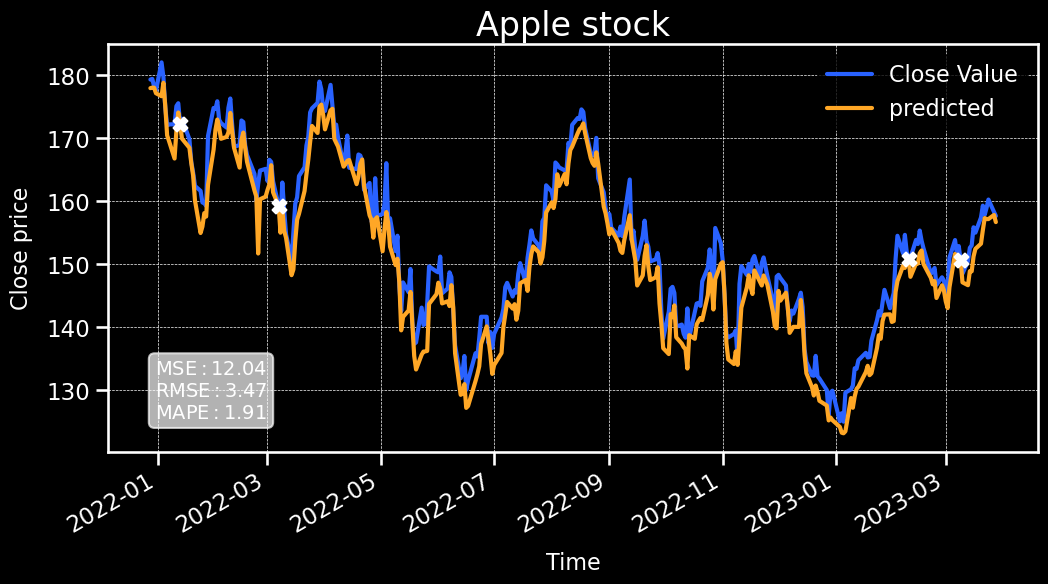

In [20]:
mse, mse_squar, mape = evaluate(y_test, y_pred, show=False)

plot_predictions(X, y_test, y_pred, mse, mse_squar, mape, predictor)